# Approaching a 3D Hot Jupiter Model With PLUTO
## Summary of Key Attributes of the Setup
### definitions.h
- HD physics module
- Spherical geometry
- Rotating frame
- 3 day rotation period
- Radial coordinate extends to 1.6 times the radius of Jupiter

### pluto.ini
**Grid and solver**
- X1-grid (radius): 2 coordinate patches, each with with uniform spacing
    - 0.01 to 1.0 has 20 elements
    - 1.0 to 1.2 has 10 elements
- X2-grid (elevation): 1 coordinate patch with 36 elements, extending $\pm80^\circ$ above the equator
- X3-grid (azimuth): 1 coordinate patch with 80 elements, wrapping around the globe completely
- CFL = 0.25 with max var 1.1
- hllc solver
- van Leer limiter

**Boundary conditions**
- X1-beg: axisymmetric
- X1-end: userdef
- X2-beg: reflective
- X2-end: reflective
- X3-beg: periodic
- X3-end: periodic

**User parameters**
- ALPHA = 10.0

### init.c
**Body force**
- The gravitational field is given by
$$
g = 
   \begin{cases} 
      -1/R^2           & \quad{\rm for} \quad R > 1 \\
      aR + bR^2 + cR^3 & \quad{\rm for} \quad R < 1 \\
   \end{cases}
$$
Additionally, the rotating frame weakens the effect of gravity in proportion to the cylindrical radius (about the axis of rotation) due to centrifugal force. PLUTO handles this internally for all dynamics, but the centrifugal force needs to be accounted for manually in initial and boundary conditions. This is still a TODO.

**Initial conditions**
- The density field is initialized to a state of hydrostatic equilibrium (TODO: account for centrifugal force)
- All velocities are initially 0
- Angular velocity of rotating frame is $$\Omega_z = \frac{L}{V T_r}=\frac{(1.6*6.9911\times10^9 [cm]) / 1.2}{10^5 [cm/s] \times3*34*3600 [s]}=0.357$$ in code units, where $L$ and $V$ are the unit length and velocity, respectively, and $T$ is the period of rotation. Note that we define $L$ as the planet radius, $R_p$, divided by the end coordinate of the radius grid ($1.2$) so that unit radius ($1.0$) corresponds to the gravitational field transition from the interior of the planet to the exterior, and maximum radius ($1.2$) corresponds to the edge of the atmosphere

**Boundary conditions**
- At the end of the radial coordinate, all velocities are 0
- At the end of the radial coordinate, density is set to $exp\big(\alpha(\frac{1}{R}-1)\big)$ and pressure is set to $\rho/\alpha$ (isothermal)

**Winds (internal boundary condition)**
- Winds can be enabled using an internal boundary condition, which forces a certain $v_{phi}$ profile in the upper 10% of the fluid
    - Exponential profile (`#define WINDS_EXP`): $$exp\big(10(R/R_p - 1)\big) sin(m\theta + b)$$
    - Quadratic profile (`#define WINDS_QUAD`): $$\bigg(\frac{R}{R_p}\bigg)^2sin(m\theta + b)$$
Where $m$ and $b$ are constants used to make the profiles maximum at the equator, and $0$ at the ends of the elevation grid

# Analysis of Results

In [1]:
%matplotlib inline

import os
import sys
import numpy as np

import matplotlib
#matplotlib.use('agg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyPLUTO as pp

from __future__ import print_function

## Loading Data
Make sure ```path_to_script```, below, is set to the location where this script is running

In [2]:
path_to_script = os.path.join(os.environ['PLUTO_DIR'], 'Work\\')
w_dir = os.path.join(path_to_script, "data")
print("Loading data from", w_dir)

data_dirs = [directory for directory in os.listdir(os.path.join(w_dir)) if "." not in directory]
print("Found data directories: ")
i = 0
for dir in data_dirs:
    print("\t{0}: {1}".format(i, dir))
    i = i + 1

Loading data from D:\PLUTO\Work\data
Found data directories: 
	0: 10t_centrifugal_exp_winds
	1: 10t_centrifugal_exp_winds_old
	2: 10t_centrifugal_no_winds
	3: 10t_centrifugal_no_winds_old
	4: 3t_centrifugal_no_winds
	5: 3t_centrifugal_no_winds_old
	6: 3t_with_centrifugal
	7: centrifugal_exp_winds_tau2p8
	8: centrifugal_exp_winds_tau5p6
	9: centrifugal_exp_winds_tau8p4
	10: centrifugal_exp_winds_vr0_vtheta0
	11: centrifugal_no_winds
	12: centrifugal_no_winds_vr0_vtheta0
	13: disk_planet_no_rotation
	14: disk_planet_rotation
	15: res_20u10u_36_40
	16: res_20u10u_36_40_alpha31p3
	17: res_20u10u_36_40_alpha3p13
	18: res_26_37_40
	19: res_26_74_80
	20: rotating
	21: rotating_ic
	22: rotating_ic_3d
	23: rotating_ic_3d_outflow
	24: rotating_ic_6d
	25: rotating_potential
	26: rotating_winds_10t
	27: rotating_winds_25t_outflow_exp
	28: rotating_winds_25t_outflow_quad
	29: rotating_winds_25t_reflective_exp
	30: rotating_winds_25t_reflective_quad
	31: rotating_winds_3t_outflow_exp
	32: rotating_w

Next, we may have a choice between different data sets to load. These have been enumerated above. To change the data set, change the value of `set_idx`, below to one of the other indices.

In [3]:
set_idx = 11
wdir = os.path.join(w_dir, data_dirs[set_idx] + os.sep)
print("Using working directory", wdir)

Using working directory D:\PLUTO\Work\data\centrifugal_no_winds\


Next, we use pyPLUTO to load the data in ```wdir``` into a ```pload``` object. ```dh[n]``` is the data handle for data.```n```.dbl.

In [4]:
n_frames = len([file for file in os.listdir(wdir) if "data" in file and ".dbl" in file])
dh = list() # List of data handles
for i in range(n_frames):
    d = pp.pload(i, w_dir = wdir)
    dh.append(d)

Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0000.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0001.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0002.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0003.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0004.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0005.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0006.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0007.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0008.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0009.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0010.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0011.dbl
Reading Data file : D:\PLUTO\Work\data\centrifugal_no_winds\data.0012.dbl
Reading Data file : D:\PLUTO\Work\data

## 2D Plots
We now define a function to help us with plotting, and also perform some one-time plot configurations.

In [46]:
# TODO(Tyler): instead of simply passing in True or False, we should be able to specify
# the desired elevation angle, or azimuthal angle and then choose the closest value
# that we have on the grid
def plot_2d(
    data,
    const_elevation=False,
    const_azimuth=False,
    log=False,
    first_only=False,
    field='',
    arrows=False,
    v_min=float('inf'),
    v_max=float('inf')
):
    '''
    Plots scalar and vector field quantities.
    
    Parameters
    ----------
    data : list of pyPLUTO.pload
        List of data frames
    const_elevation : bool
        If True, plots the density as a function of radius and elevation
        Exclusive to const_azimuth
    const_azimuth : double
        If True, plots the density as a function of radius and azimuth
        Exclusive to const_elevation
    log : bool
        (Optional) Plots the logarithm for scalar fields (base 10)
    first_only : bool
        (Optional) Causes only the first frame to be plotted
    field : str
        The field quantity to plot
            - "rho" for density
            - "v_phi" for azimuthal velocity
            - "v_r" for radial velocity
            - "v_theta" for meridional velocity
    arrows : bool
        Switch to plot velocity vectors
    v_min : float
        Specifies what the colorbar's min color should be
    v_max : float
        Specifies what the colorbar's max color should be
    '''
    
    if const_elevation == False and const_azimuth == False:
        const_elevation = True
    
    # Sanity check on inputs
    assert(const_elevation != True or const_azimuth != True), "EITHER the azimuth or elevation may be specified, not both"
    assert(field == '' or field == 'rho' or field == 'v_phi' or field == 'v_r' or field == 'v_theta'), "field argument is invalid"
    assert(not (field == '' and log == True)), "Cannot do log plot if no field quantity is specified"
    
    default_vmin = v_min == float('inf')
    default_vmax = v_max == float('inf')
    
    nframes = 1 if first_only else len(data)
    nrows   = 1 if first_only else np.round(np.sqrt(nframes))
    ncols   = 1 if first_only else np.round(np.sqrt(nframes) + 1)
    
    theta = 90 # Equator
    phi = 0
    theta_idx = (np.abs(dh[0].x2 - theta * np.pi / 180)).argmin()
    phi_idx = (np.abs(dh[0].x3 - phi * np.pi / 180)).argmin()
    for idx in range(nframes):
        if const_azimuth:
            X = data[idx].x1
            Y = (180 / np.pi) * (data[idx].x2 - np.mean(data[idx].x2))
            U = data[idx].vx1[:,:,phi_idx].T
            V = data[idx].vx2[:,:,phi_idx].T
            annotations = [field, 'X1 (radius)', 'X2 (elevation)']
            if field == 'rho':
                qty =  data[idx].rho[:,:,phi_idx].T
            elif field == 'v_r':
                qty =  data[idx].vx1[:,:,phi_idx].T
            elif field == 'v_theta':
                qty =  data[idx].vx2[:,:,phi_idx].T
            elif field == 'v_phi':
                qty =  data[idx].vx3[:,:,phi_idx].T
        elif const_elevation:
            X = data[idx].x1
            Y = (180 / np.pi) * data[idx].x3
            U = data[idx].vx1[:,theta_idx,:].T
            V = data[idx].vx3[:,theta_idx,:].T
            annotations = [field, 'X1 (radius)', 'X3 (azimuth)']
            if field == 'rho':
                qty = data[idx].rho[:,theta_idx,:].T
            elif field == 'v_r':
                qty =  data[idx].vx1[:,theta_idx,:].T
            elif field == 'v_theta':
                qty =  data[idx].vx2[:,theta_idx,:].T
            elif field == 'v_phi':
                qty =  data[idx].vx3[:,theta_idx,:].T
        
        plt.subplot(nrows, ncols, idx + 1)
        if field != '':
            if log:
                qty = np.log10(qty)
            if v_min == float('inf'):
                v_min = np.floor(np.min(qty))
            if v_max == float('inf'):
                v_max = np.ceil(np.max(qty))
            annotations[0] = "Log10 " + annotations[0]
            plt.pcolormesh(X, Y, qty, vmin=v_min, vmax=v_max)
            if ((idx != 0 and (idx+1) % ncols == 0) or idx == nframes-1):
                plt.colorbar()
        
        if arrows:
            plt.quiver(X, Y, U, V)

        annotations[0] = annotations[0] +  ' (time: ' + str(np.round(data[idx].SimTime, 2)) + ')'
        plt.title(annotations[0])
        plt.xlabel(annotations[1])
        if (idx % ncols == 0):
            plt.ylabel(annotations[2])


def save_plt(fname, w_dir=wdir):
    '''
    Saves plots to the working directory
    
    Parameters
    ----------
    fname : str
        The name to be given to the image file
    wdir : str
        (Optional) The location where the file is to be saved
    '''
    plt.savefig(os.path.join(w_dir, fname) + '.png')


# Inches
width = 20
height = 25

# One-time plot configuration
plt.rcParams['figure.figsize'] = [width, height]
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

We now fix the azimuth, and plot how the density varies with radius and elevation. The code below will either plot this relationship for only the first time snapshot, or for all time snapshots depending on whether `only_plot_first_frame`, below, is `True` or `False`.

## Density

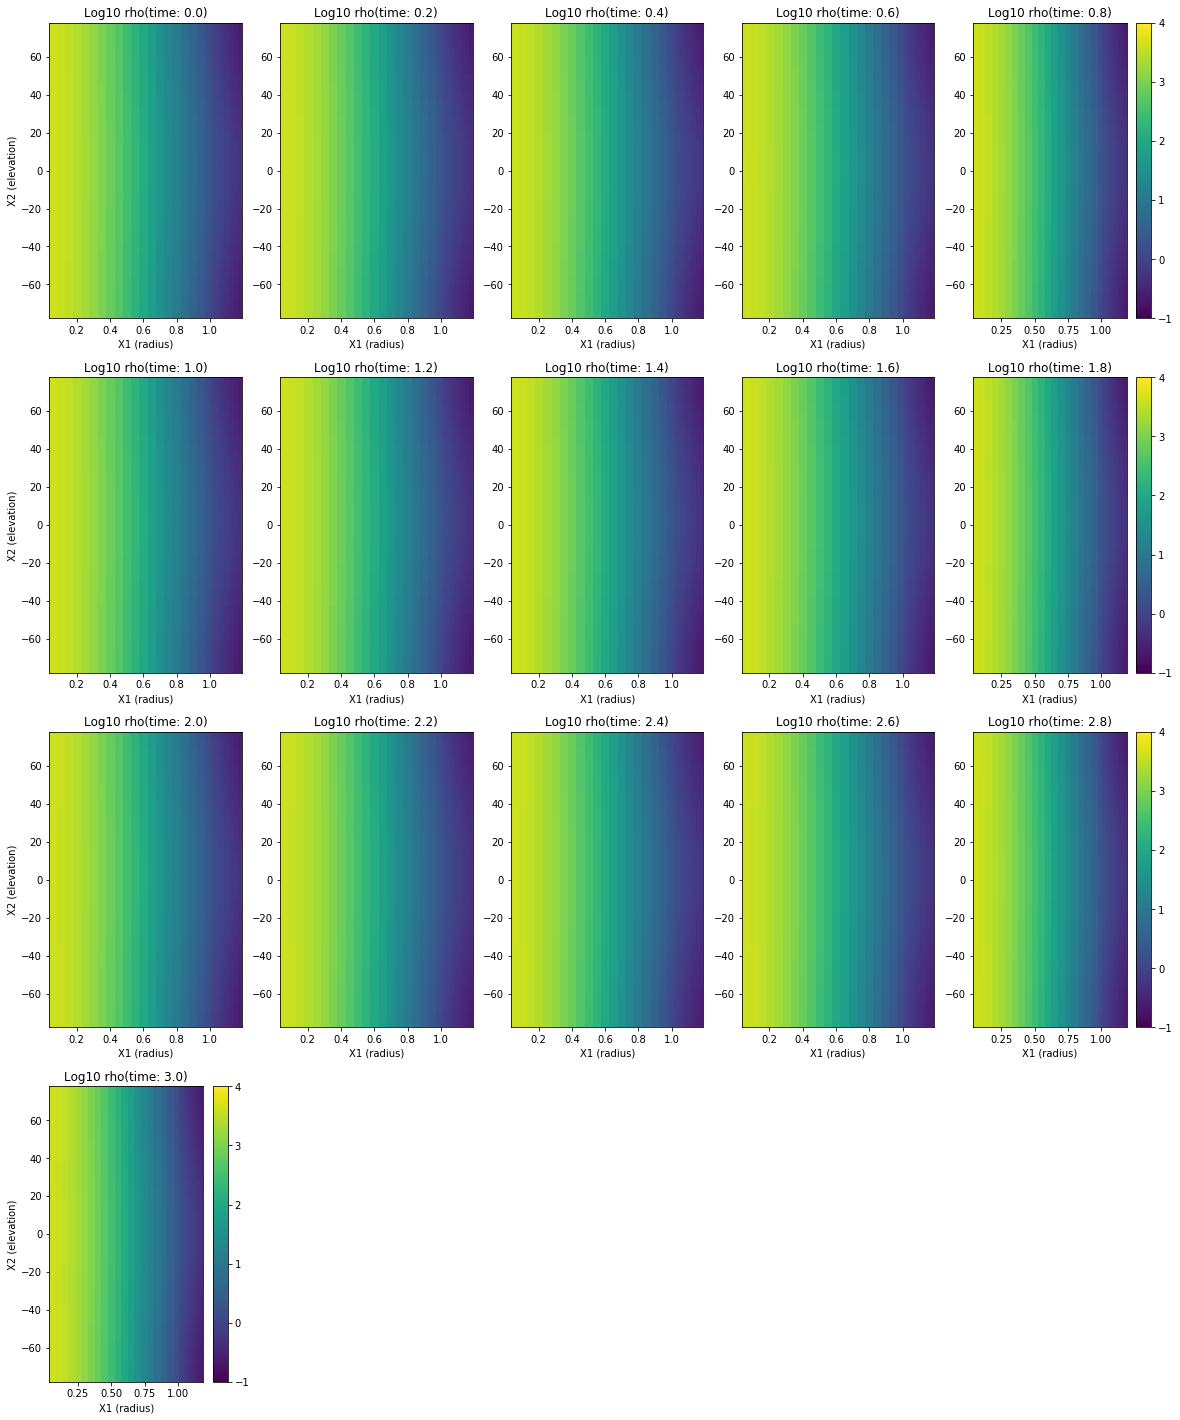

In [35]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_2d(dh, const_azimuth=True, log=True, first_only=only_plot_first_frame, field='rho')
save_plt('rho_vs_rad_vs_lat')

When we plot all the frames, we can see that the density is fairly constant with time along these 2 coordinates. Also, we observe that along a circle with fixed radius, the density is constant as the elevation is varied (i.e. in the plots above, vertical lines of density are constant).

Now we fix the elevation, and plot how the density varies with radius and azimuth. The code below will either plot this relationship for only the first time snapshot, or for all time snapshots depending on whether `only_plot_first_frame`, below, is `True` or `False`.

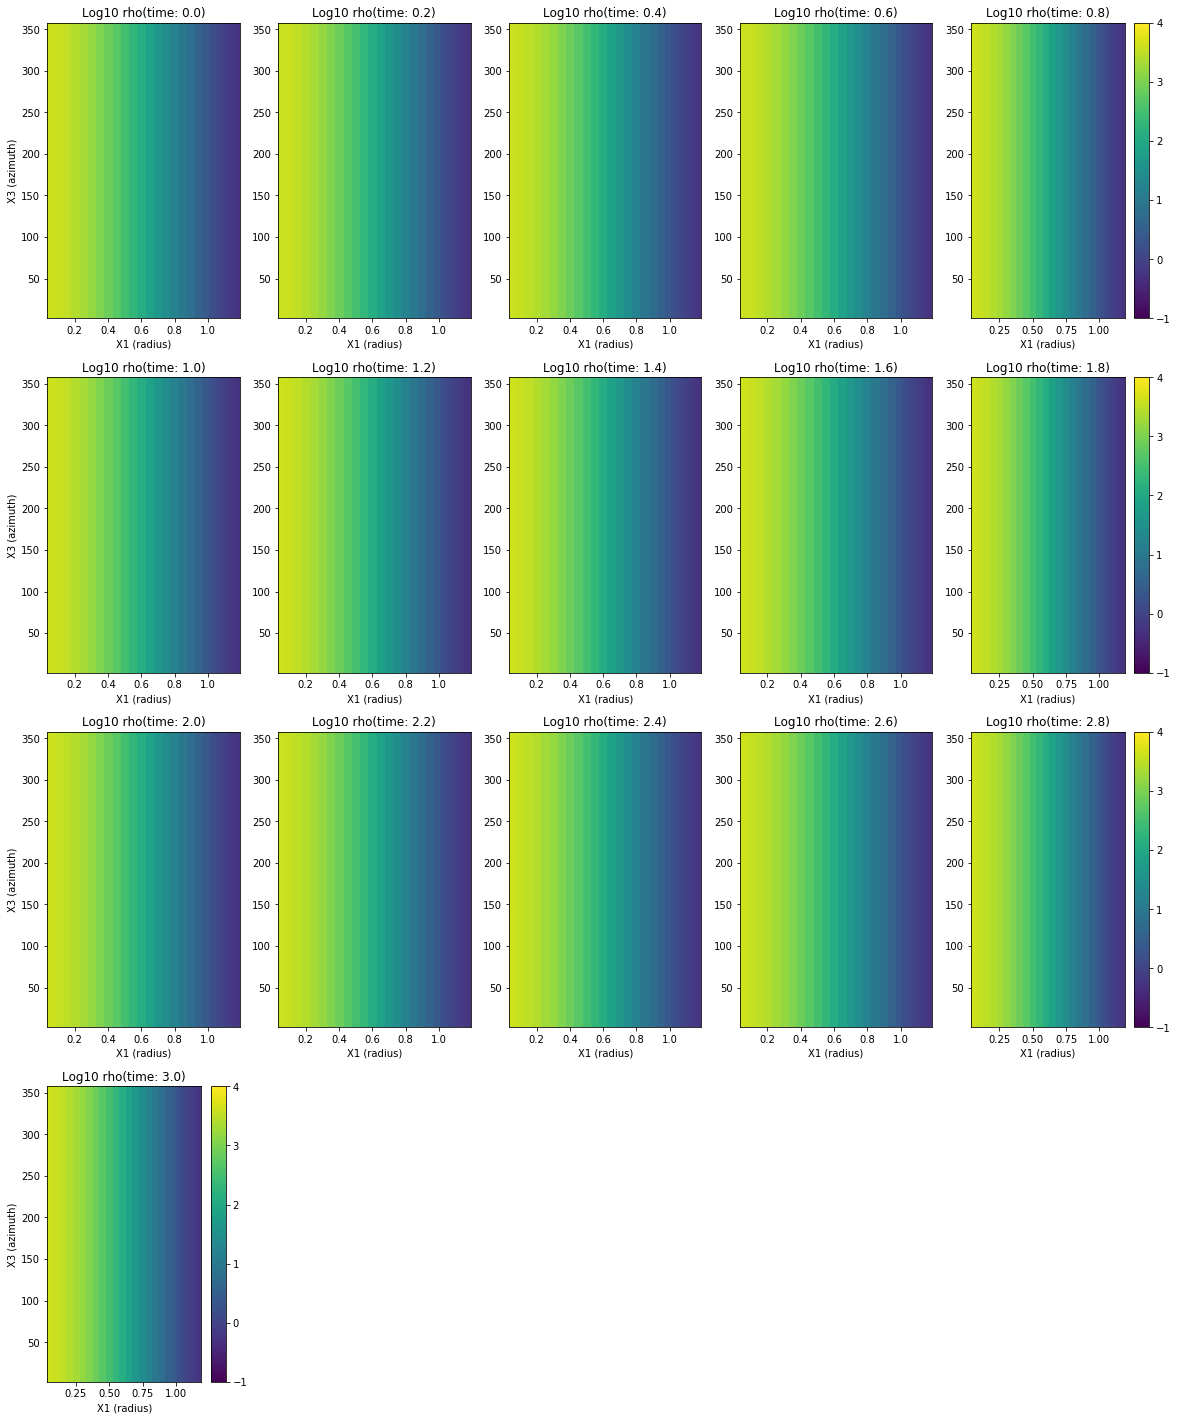

In [26]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames
plot_2d(dh, const_elevation=True, log=True, first_only=only_plot_first_frame, field='rho')
save_plt('rho_vs_rad_vs_lon')

We observe that concentric circles centred on the equatorial plane have constant density for a fixed radius. This confirms that the atmosphere is stratified.

## Azimuthal Velocity
We now specify `'v_phi'` for the field argument. Note that all velocities are in km/s.

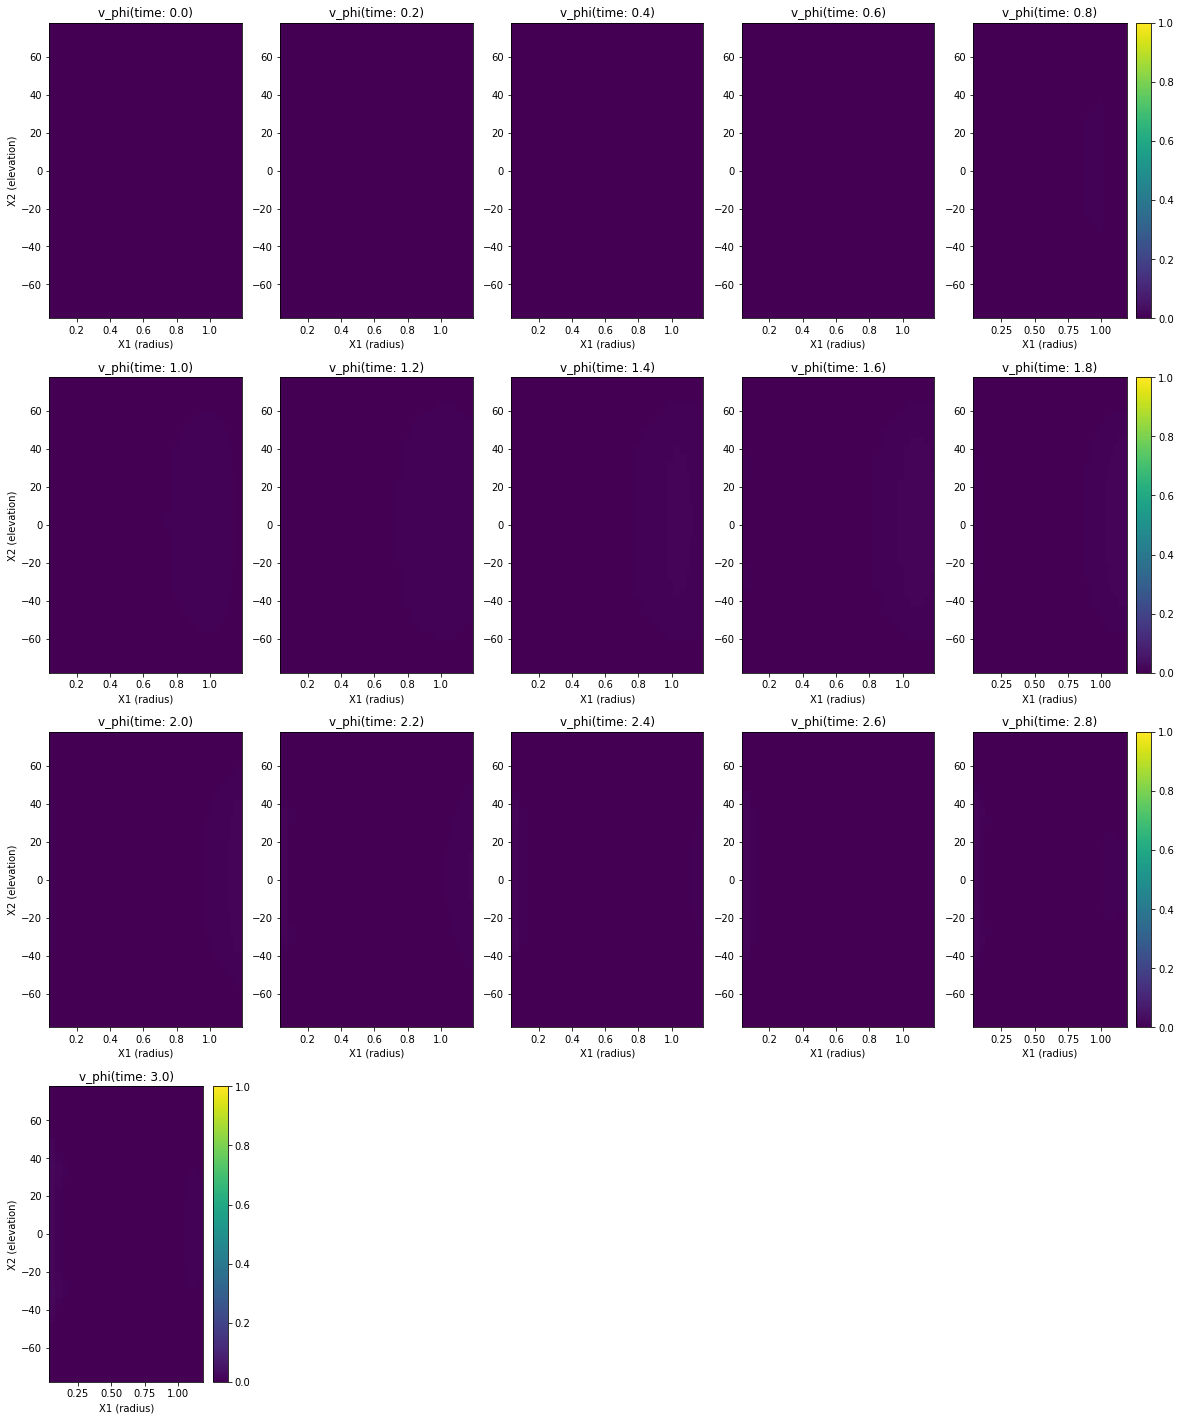

In [27]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_2d(dh, const_azimuth=True, first_only=only_plot_first_frame, field='v_phi', v_max=1.0, v_min=0)
save_plt('vphi_vs_rad_vs_lat')

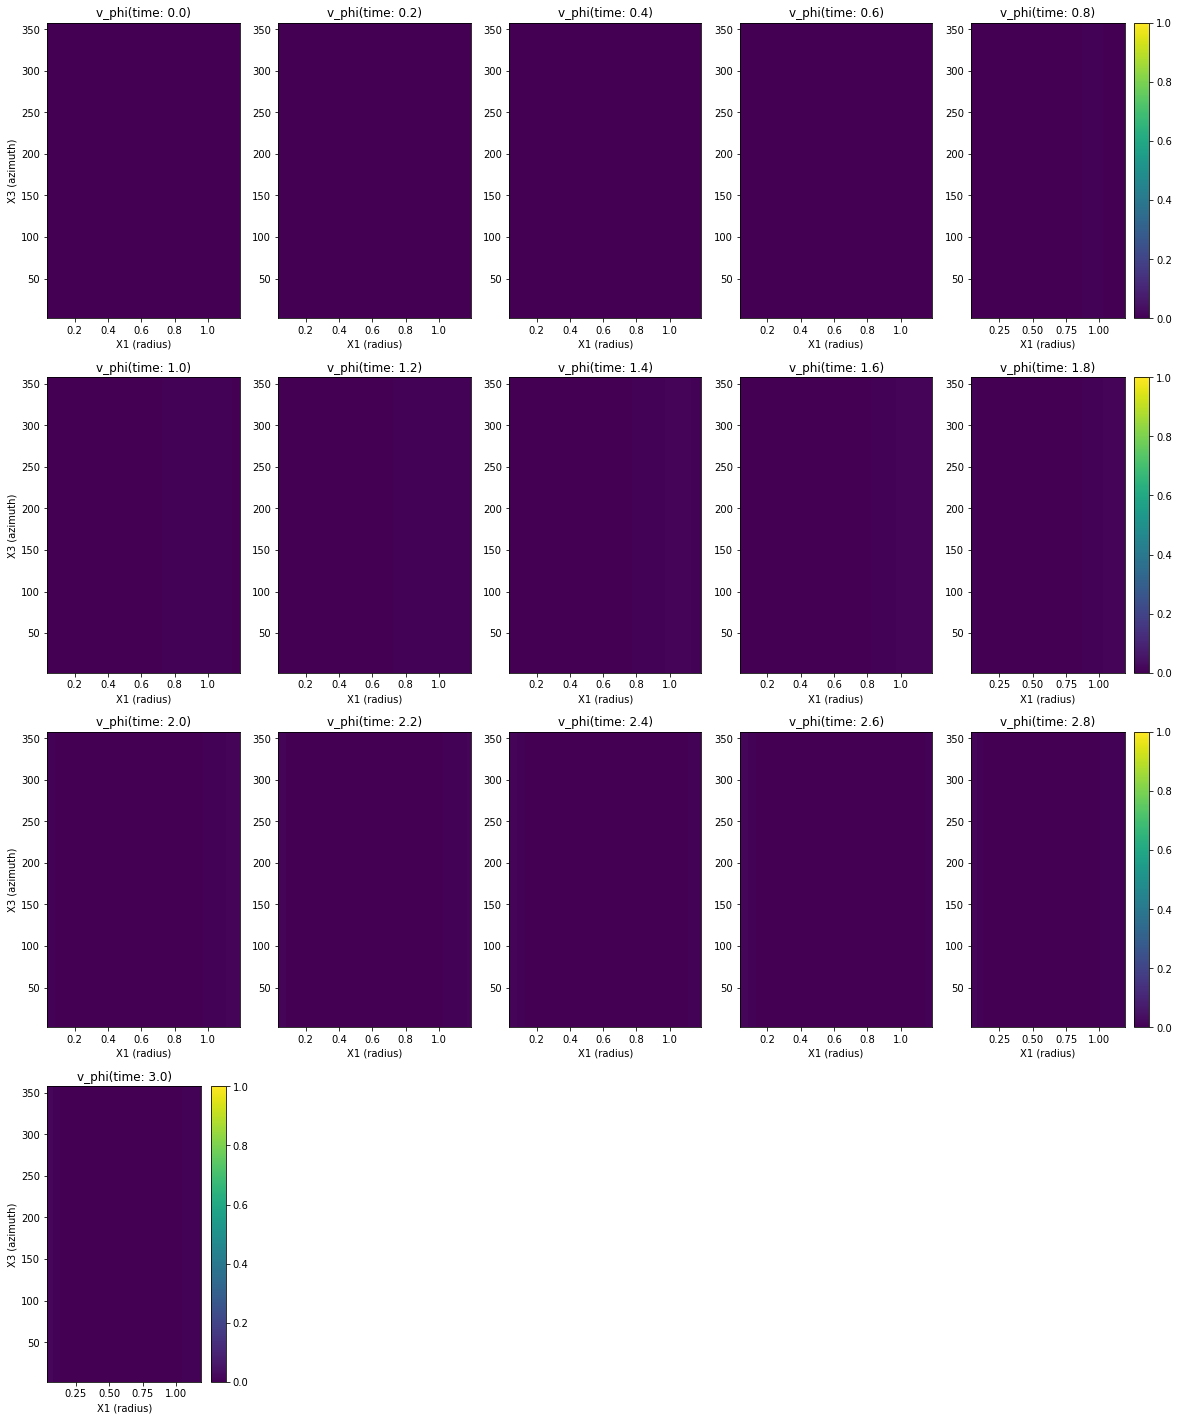

In [28]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_2d(dh, const_elevation=True, first_only=only_plot_first_frame, field='v_phi', v_max=1.0, v_min=0)
save_plt('vphi_vs_rad_vs_lon')

## Radial Velocity
We now specify `'v_r'` for the field argument. Note that all velocities are in km/s.

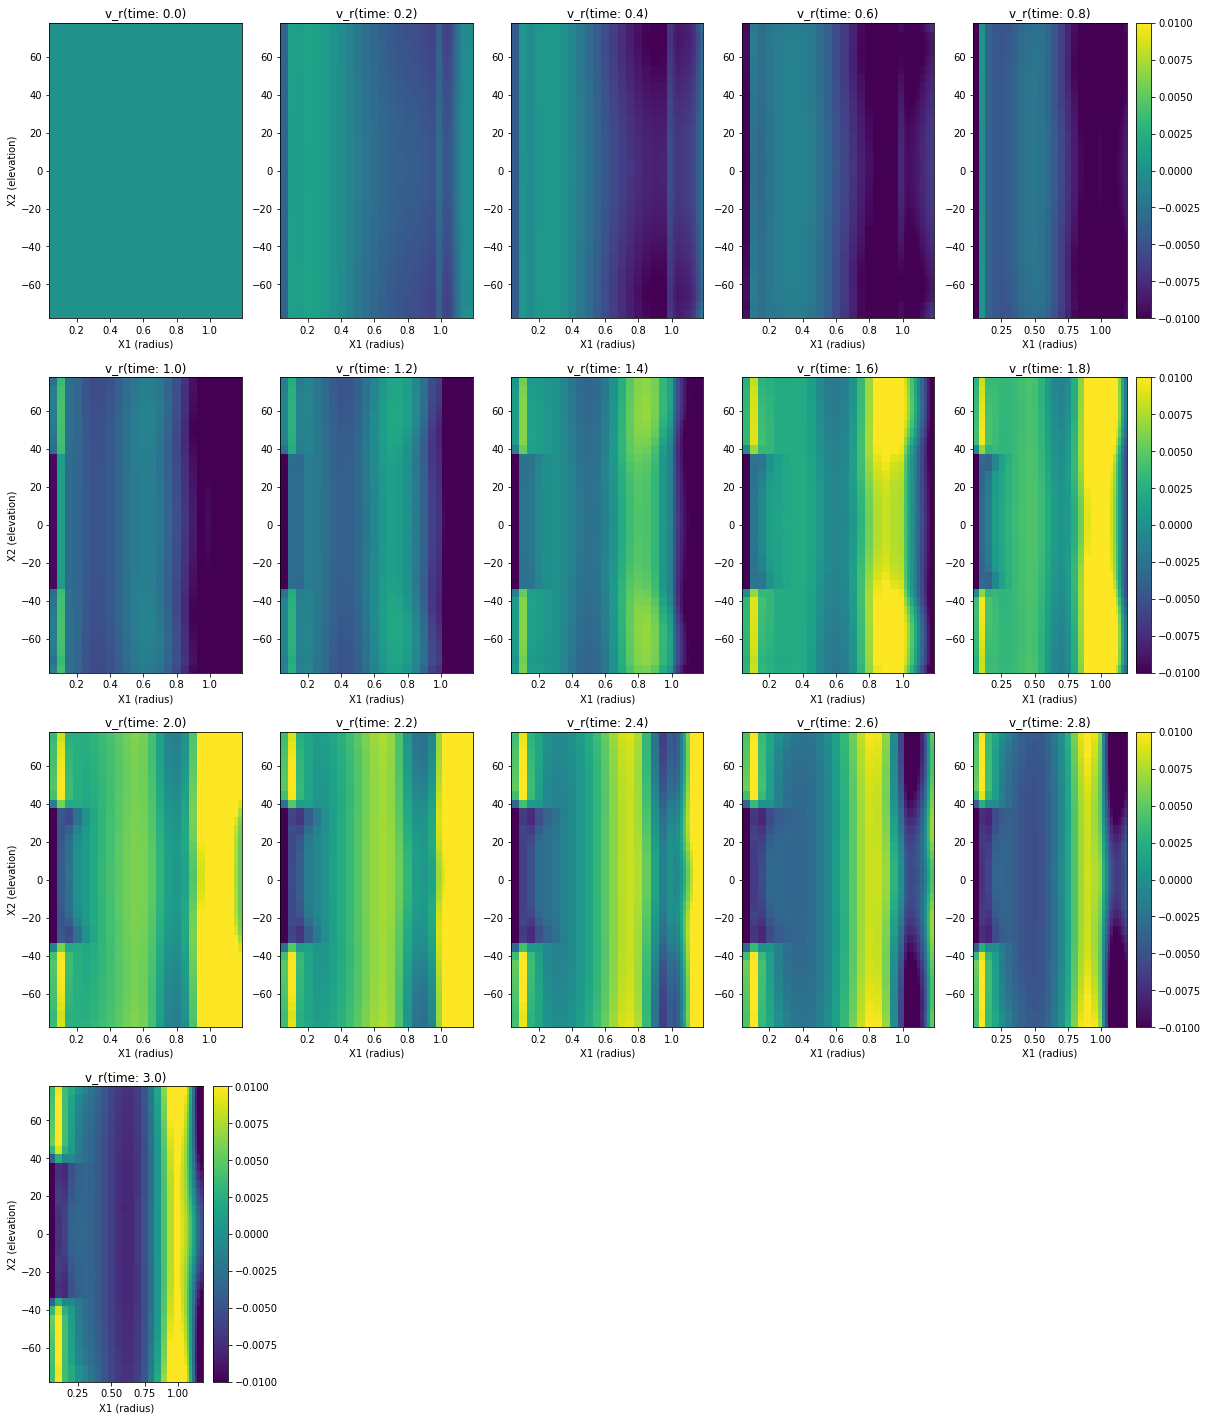

In [29]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_2d(dh, const_azimuth=True, first_only=only_plot_first_frame, field='v_r', v_min=-0.01, v_max=0.01)
save_plt('vr_vs_rad_vs_lat')

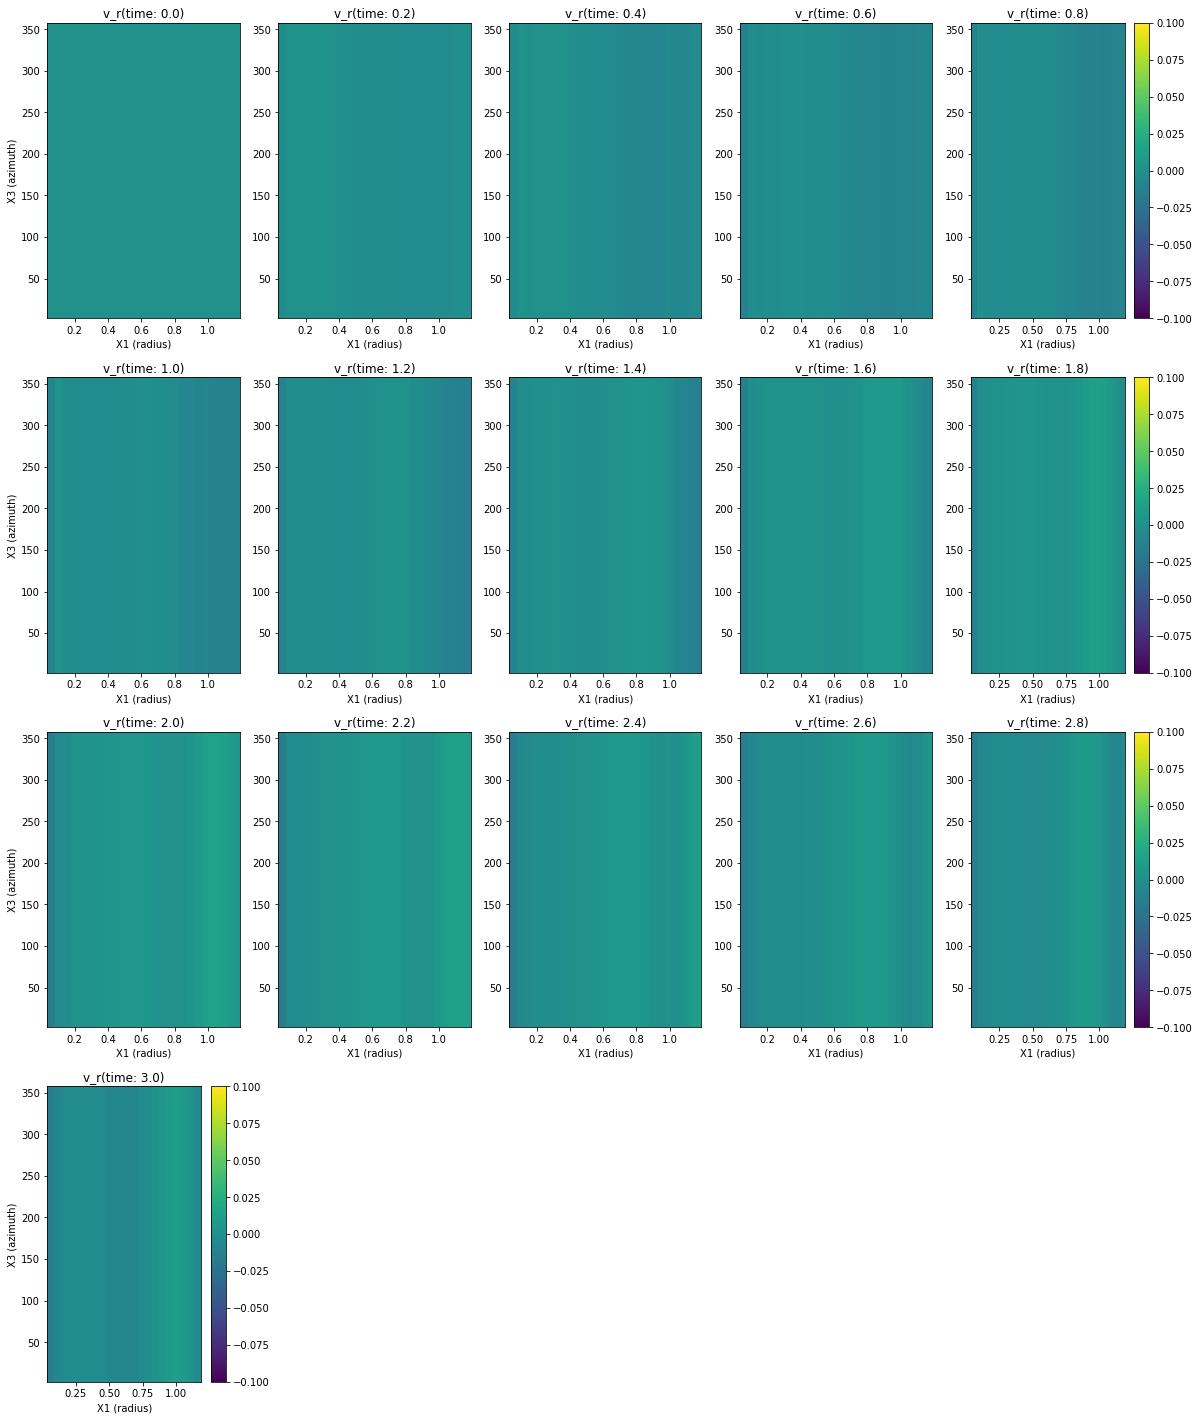

In [30]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_2d(dh, const_elevation=True, first_only=only_plot_first_frame, field='v_r', v_min=-0.1, v_max=0.1)
save_plt('vr_vs_rad_vs_lon')

## Meridional Velocity
We now specify `'v_theta'` for the field argument. Note that all velocities are in km/s.

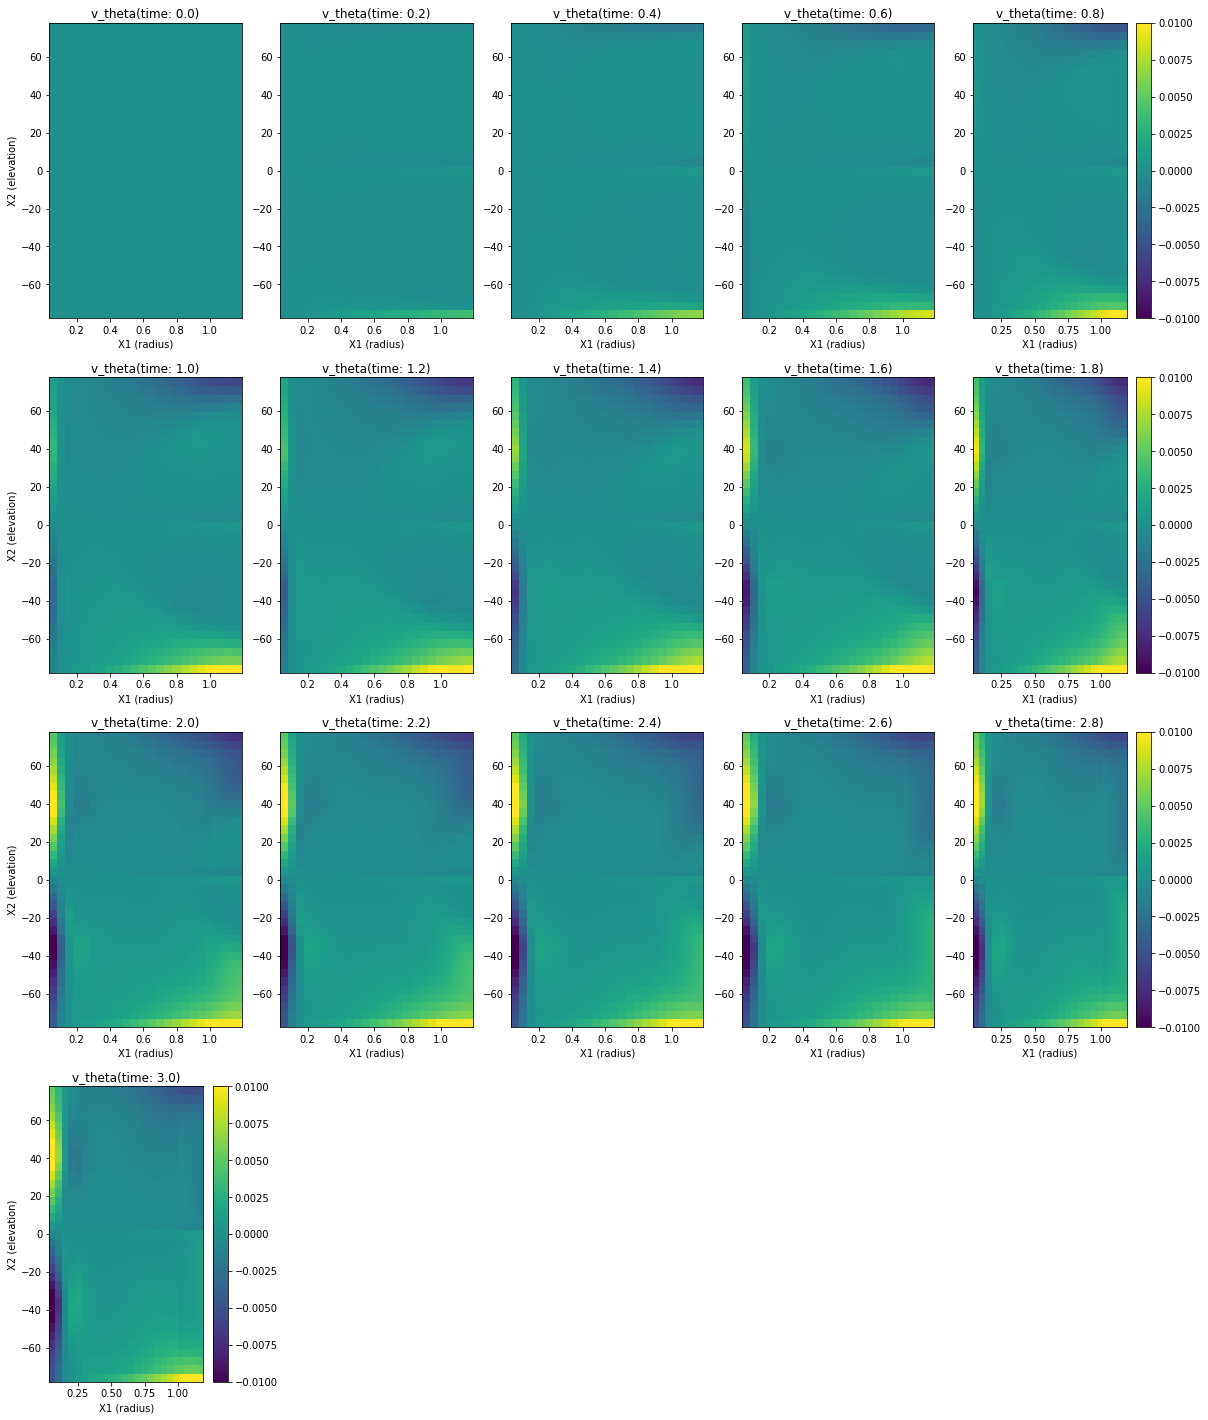

In [31]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_2d(dh, const_azimuth=True, first_only=only_plot_first_frame, field='v_theta', v_min=-0.01, v_max=0.01)
save_plt('vtheta_vs_rad_vs_lat')

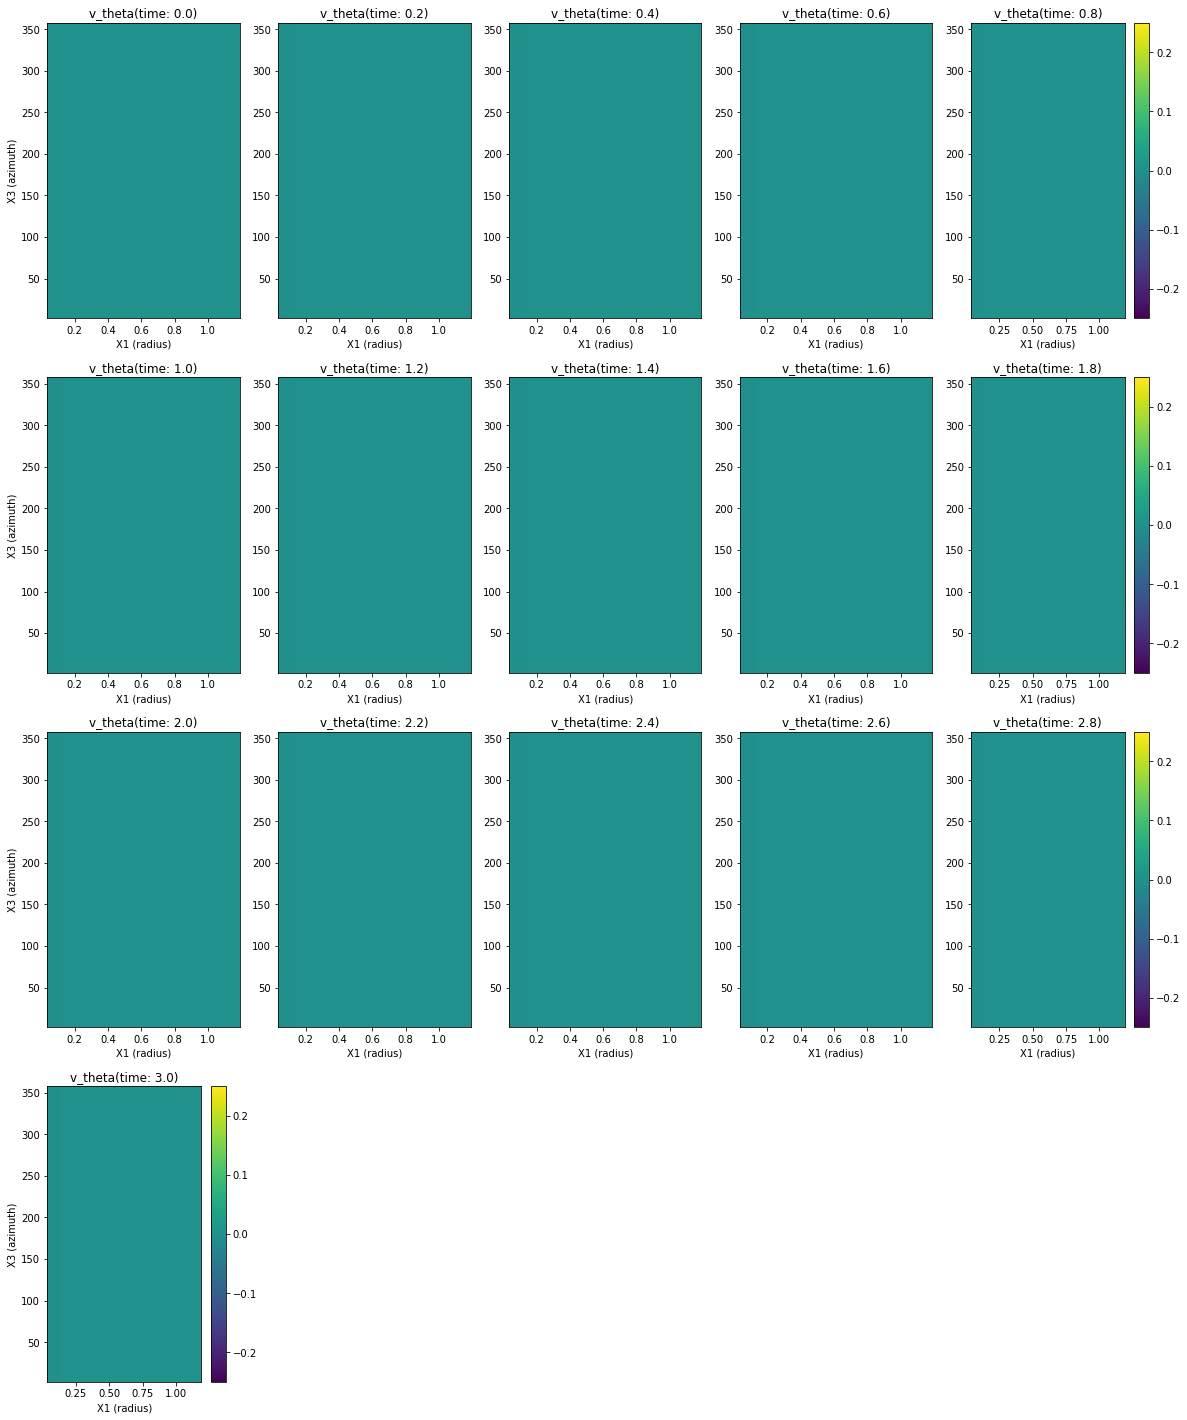

In [32]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_2d(dh, const_elevation=True, first_only=only_plot_first_frame, field='v_theta', v_min=-0.25, v_max=0.25)
save_plt('vtheta_vs_rad_vs_lon')

# Vector plots

In [ ]:
fig = plt.figure()

only_plot_first_frame = False # Make this False to plot for all time frames

plot_2d(dh, const_azimuth=True, first_only=only_plot_first_frame, log=True, field='rho', arrows=True)
#plot_2d(dh, const_azimuth=True, first_only=only_plot_first_frame, arrows=True)
save_plt('vector_vr_vtheta')

## Radial Density Profile
Here we will plot how the density varies with radius, when the elevation and azimuth are fixed. We will define this as a general-purpose function so that we can reuse it.

In [44]:
def subplot_radius_vs_density_2d(data, theta, phi, log=False, first_only=False):
    '''
    Plots density profiles as a function of the radius for fixed theta and phi, for
    all time steps.
    
    Parameters
    ----------
    data : list of pyPLUTO.pload
        List of data frames
    theta : double
        The desired elevation angle (spherical coordinates)
    phi : double
        The desired azimuthal angle
    log : bool
        (Optional) Plots the logarithm of the density (base 10)
    first_only : bool
        (Optional) Causes only the first frame to be plotted
        
    Note that the values specified for theta and/or phi may not exist on the grid since
    it is discrete. The closest value will be used in such cases.
    '''
    
    theta_idx = (np.abs(dh[0].x2 - theta * np.pi / 180)).argmin()
    phi_idx = (np.abs(dh[0].x3 - phi * np.pi / 180)).argmin()
    
    nframes = 1 if first_only else len(data)
    nrows   = 1 if first_only else np.round(np.sqrt(nframes))
    ncols   = 1 if first_only else np.round(np.sqrt(nframes) + 1)
    for idx in range(nframes):
        plt.subplot(nrows, ncols, idx + 1)
        qty = np.log10(dh[idx].rho[:, theta_idx, phi_idx])
        plt.scatter(dh[idx].x1, qty)
        plt.title('Time: ' + str(np.round(dh[idx].SimTime, 2)) +
                  ' (theta = ' + str(np.round(dh[idx].x2[theta_idx] * 180 / np.pi, decimals=1)) +
                  ', phi = ' + str(np.round(dh[idx].x3[phi_idx] * 180 / np.pi, decimals=1)) + ')'
        )
        plt.xlabel('X1 (radius)')
        plt.ylabel('Log 10 Density')

### North Pole

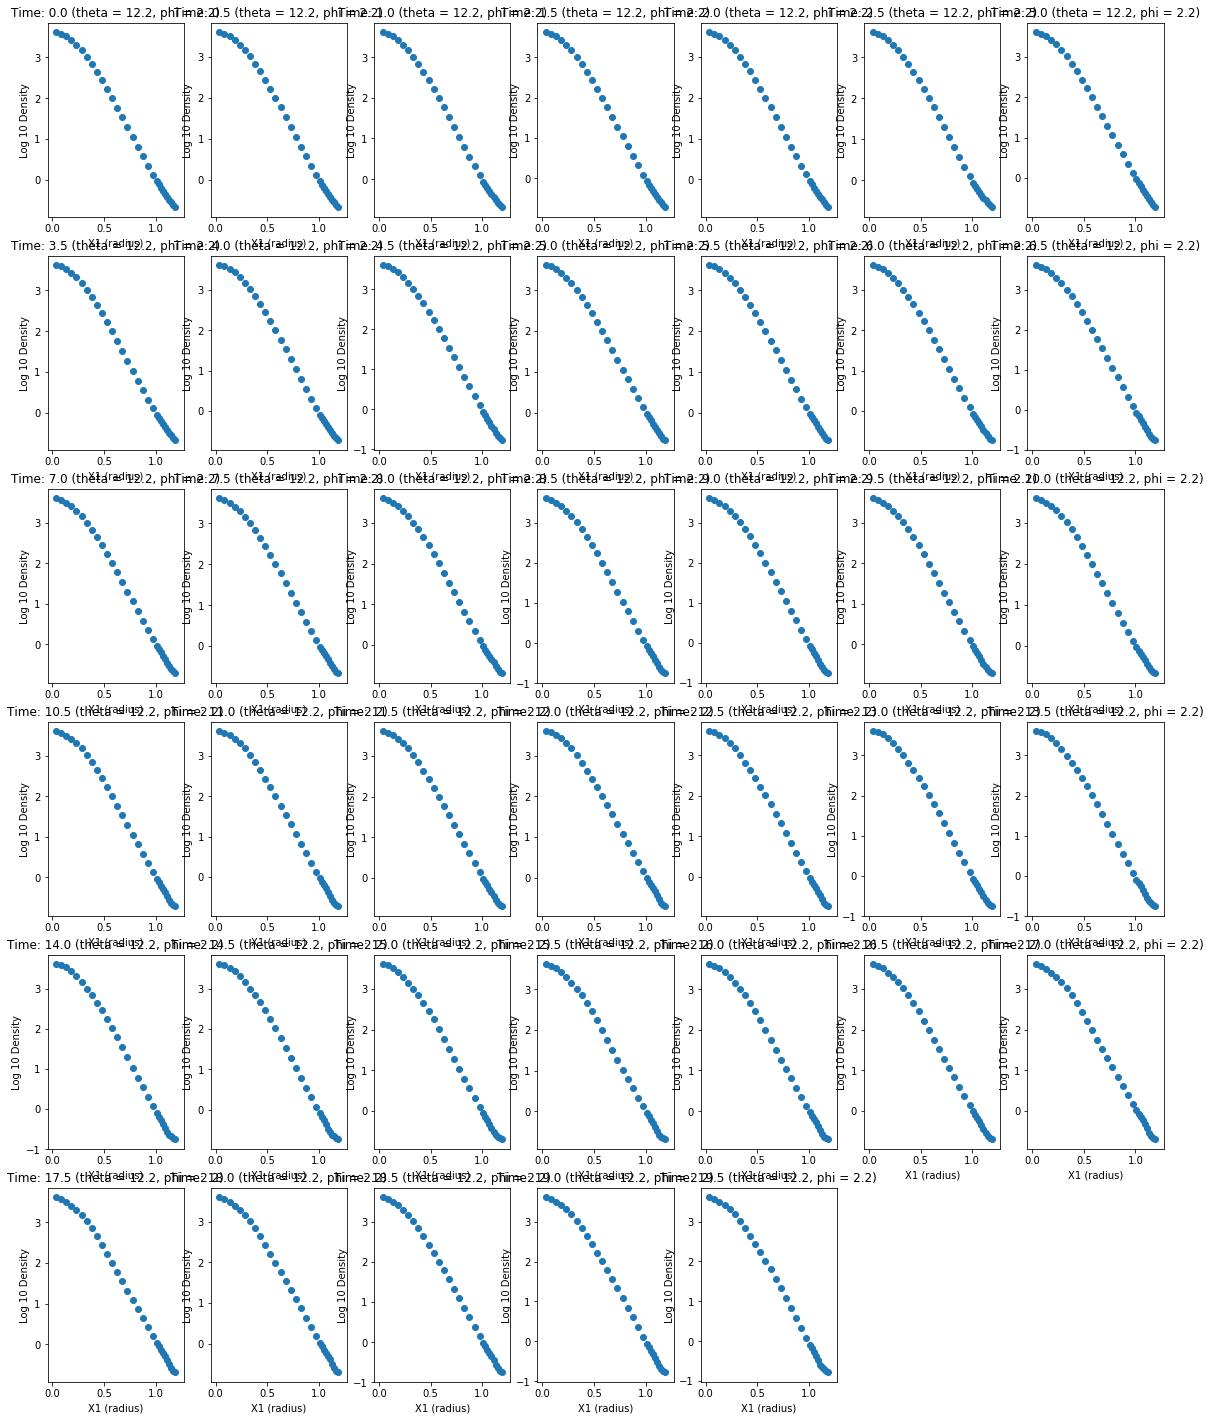

In [45]:
subplot_radius_vs_density_2d(dh, 0, 0, first_only=False);
save_plt('rho_vs_rad_north_pole_profile')

### Equator

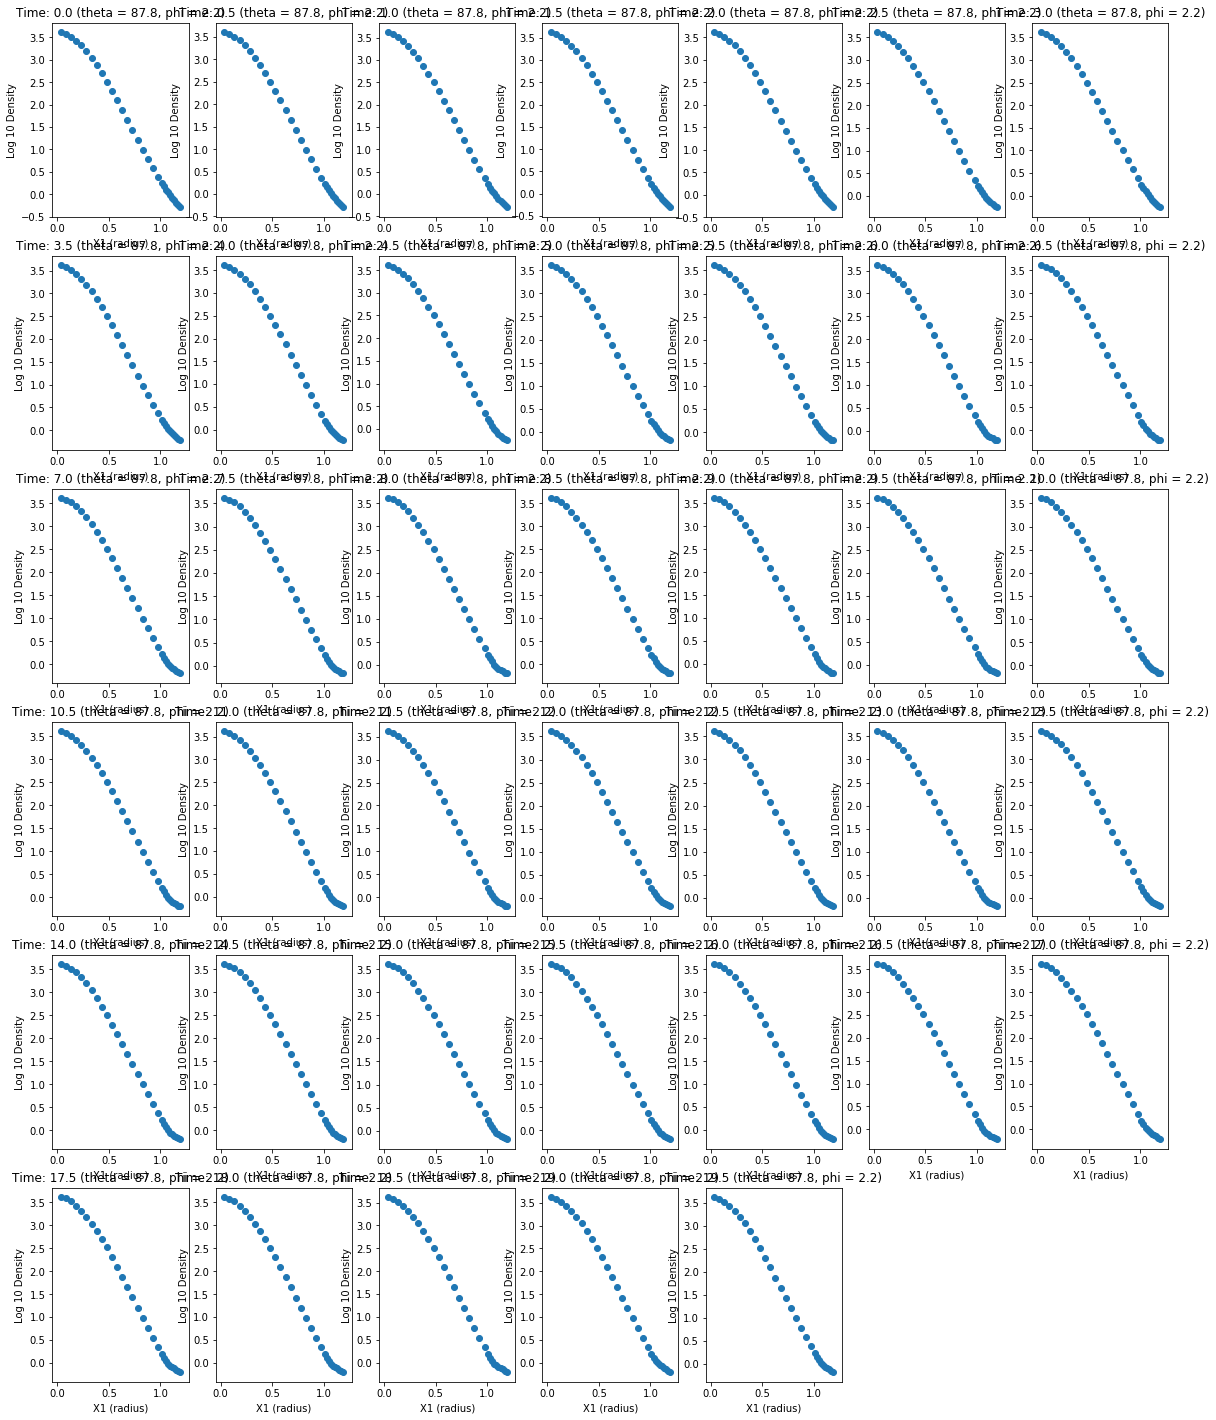

In [46]:
subplot_radius_vs_density_2d(dh, 90, 0, first_only=False);
save_plt('rho_vs_rad_equator_profile')

### South Pole

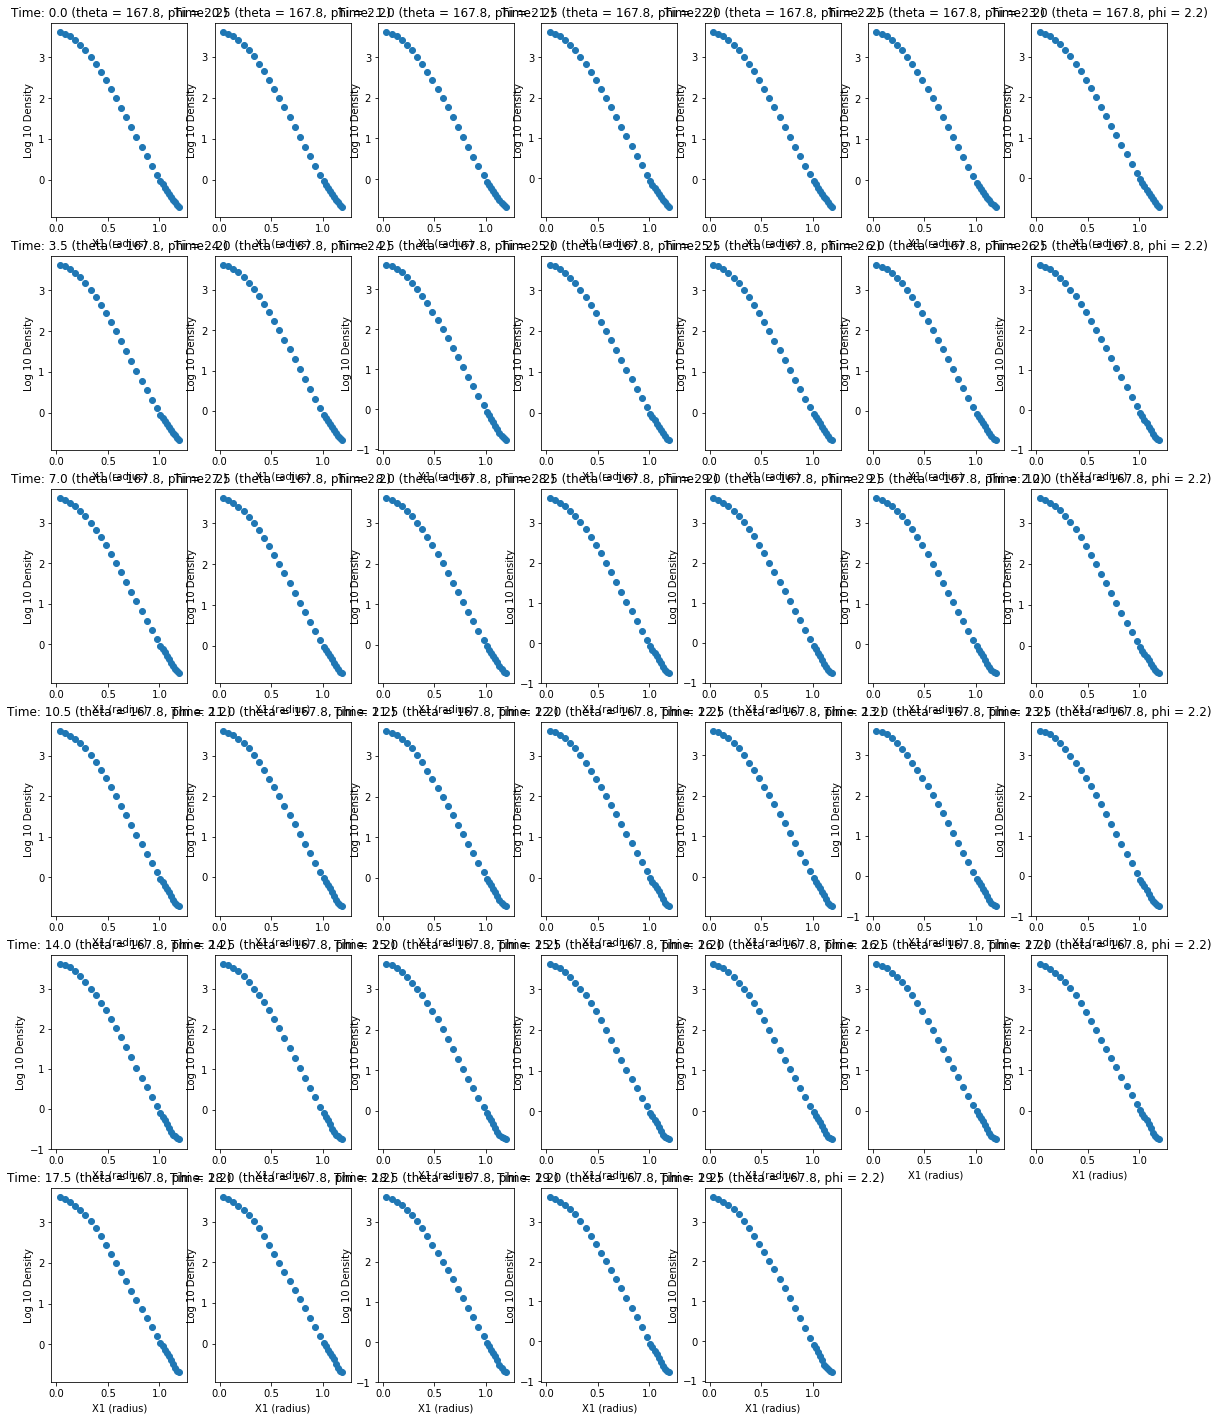

In [47]:
subplot_radius_vs_density_2d(dh, 180, 0, first_only=False);
save_plt('rho_vs_rad_south_pole_profile')

## Profile for 3 Different Alphas
$\alpha$ in pluto.ini is related to the speed of sound and thus it affects density distribution

In [ ]:
path_to_script = os.path.join(os.environ['PLUTO_DIR'], 'Work\\')
wdir = os.path.join(path_to_script, "data")

data_dirs = [directory for directory in os.listdir(os.path.join(wdir)) if "." not in directory]
print(data_dirs)
# 2: res_20u10u_36_40             <--- Alpha=10
# 3: res_20u10u_36_40_alpha31p3   <--- Alpha=31.3
# 4: res_20u10u_36_40_alpha3p13   <--- Alpha=3.13
# 5: res_26_37_40
# 6: res_26_74_80

d10   = pp.pload(0, w_dir=os.path.join(wdir, data_dirs[2] + os.sep))
d31p3 = pp.pload(0, w_dir=os.path.join(wdir, data_dirs[3] + os.sep))
d3p13 = pp.pload(0, w_dir=os.path.join(wdir, data_dirs[4] + os.sep))

theta = 90
phi = 0
theta_idx = (np.abs(d10.x2 - theta * np.pi / 180)).argmin()
phi_idx = (np.abs(d10.x3 - phi * np.pi / 180)).argmin()

fig = plt.figure(figsize=(10,10))
plt.subplot(111)

colors = ['b', 'c', 'y', 'm', 'r']

qty = np.log10(d10.rho[:, theta_idx, phi_idx])
a10 = plt.scatter(d10.x1, qty, marker='o', color=colors[0])

qty = np.log10(d31p3.rho[:, theta_idx, phi_idx])
a31p3 = plt.scatter(d31p3.x1, qty, marker='o', color=colors[1])

qty = np.log10(d3p13.rho[:, theta_idx, phi_idx])
a3p13 = plt.scatter(d3p13.x1, qty, marker='o', color=colors[2])

plt.legend((a10, a31p3, a3p13),
           ('alpha=10', 'alpha=31.3', 'alpha=3.13'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.title('Time: ' + str(d10.SimTime) +
          ' (theta = ' + str(np.round(d10.x2[theta_idx] * 180 / np.pi, decimals=1)) +
          ', phi = ' + str(np.round(d10.x3[phi_idx] * 180 / np.pi, decimals=1)) + ')'
)
plt.xlabel('X1 (radius)')
plt.ylabel('Log 10 Density')


save_plt('rho_vs_rad_equator_profile_3_alphas')

## 3D Plots
First we will define some functions to help us with plotting in 3D. The scatter plots only work nicely with cartesian coordinates so we will have to convert from spherical.

In [ ]:
def sph2cart(r, theta, phi):
    '''
    Converts the inputted spherical coordinates to cartesian coordinates
    
    Parameters
    ----------
    r : double
        The radius
    theta : double
        The altitude
    phi : double
        The azimuth
    '''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


def pltSphData3D(d, qty, axes, r=-1, theta=-1, phi=-1, silent=False, f=-1, log=False):
    '''
    Displays a 3D scatter plot of the specified field quantity with one of the
    coordinates held constant.
    
    Parameters
    ----------
    d : pyPLUTO.pload
        Interface to data object
    qty : str
        Name of field quantity (e.g. 'rho' or 'prs')
    axes : matplotlib.axes.SubplotBase
        Plotting interface
    r, theta, phi : int
        (Optional) Fixes a grid index for the radius, elevation, or azimuth. This
        quantity will be kept constant throughout the plot. Only one may be set at
        a time. Defaults to a plot of constant radius.
    silent : bool
        Prints info messages when True, otherwise no messages are printed
    log : bool
        (Optional) Plots the logarithm of the field quantity (base 10)
    
    Example
    -------
    # This will use the pload object `dh` to plot the density for a constant radius.
    The radius setting of 20 fixes the radius at dh.x1[20].
    pltSphData3D(dh, 'rho', r=20)
    '''
    
    # We default to a constant radius (specifically, the innermost radius)
    if r == -1 and phi == -1 and theta == -1:
        r = 0
    
    # Sanity checks on inputs
    assert(
        (r >= 0  and phi == -1 and theta == -1) or
        (r == -1 and phi >= 0  and theta == -1) or
        (r == -1 and phi == -1 and theta >= 0 )
    ), "Only one of r, phi, and theta can be specified"
    
    assert((qty == 'rho') or (qty == 'prs')), "qty must be rho or prs"
    
    # Coordinates
    #    x1 = radial
    #    x2 = latitudinal (theta)
    #    x3 = longitudinal (azimuthal, phi)
    x, y, z, c = [], [], [], []
    
    num_r = d.x1.shape[0]
    num_theta = d.x2.shape[0]
    num_phi = d.x3.shape[0]
    
    # Select either density or pressure based on the string passed in
    if qty == 'rho':
        field = d.rho
    elif qty == 'prs':
        field = d.prs
    
    # Plot the quantity
    if(r >= 0):
        assert(r <= num_r - 1), "r is too large (must be <= {0})".format(num_r - 1)
        r_l = d.x1[r]
        if not silent:
            print("Plotting sphere of radius {0}".format(r_l))
        for i in range(num_theta):
            theta_l = d.x2[i]
            for j in range(num_phi):
                phi_l = d.x3[j]
                x_p, y_p, z_p = sph2cart(r_l, theta_l, phi_l)
                x.append(x_p)
                y.append(y_p)
                z.append(z_p)
                if log:
                    c.append(np.log(field[r,i,j]))
                else:
                    c.append(field[r,i,j])
    elif(theta >= 0):
        assert(theta <= num_theta - 1), "theta is too large (must be <= {0})".format(num_theta - 1)
        theta_l = d.x2[theta]
        if not silent:
            print("Plotting cone with elevation angle {0} deg".format(theta_l * 180 / np.pi))
        for i in range(num_r):
            r_l = d.x1[i]
            for j in range(num_phi):
                phi_l = d.x3[j]
                x_p, y_p, z_p = sph2cart(r_l, theta_l, phi_l)
                x.append(x_p)
                y.append(y_p)
                z.append(z_p)
                if log:
                    c.append(np.log(field[i,theta,j]))
                else:
                    c.append(field[i,theta,j])
    else:
        assert(phi <= num_phi - 1), "phi is too large (must be <= {0})".format(num_phi - 1)
        phi_l = d.x3[phi]
        if not silent:
            print("Plotting disk with azimuth {0} deg".format(phi_l * 180 / np.pi))
        for i in range(num_r):
            r_l = d.x1[i]
            for j in range(num_theta):
                theta_l = d.x2[j]
                x_p, y_p, z_p = sph2cart(r_l, theta_l, phi_l)
                x.append(x_p)
                y.append(y_p)
                z.append(z_p)
                if log:
                    c.append(np.log(field[i,j,phi]))
                else:
                    c.append(field[i,j,phi])
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    # Update the plot axes, but don't make them smaller
    axes.set_xlim3d(
        min(axes.get_xlim3d()[0], min(x)),
        max(axes.get_xlim3d()[1], max(x))
    )
    axes.set_ylim3d(
        min(axes.get_ylim3d()[0], min(y)),
        max(axes.get_ylim3d()[1], max(y))
    )
    axes.set_zlim3d(
        min(axes.get_zlim3d()[0], min(z)),
        max(axes.get_zlim3d()[1], max(z))
    )
    
    # Compute the max and min values used for the color
    if log:
        v_min = np.floor(np.min(np.log(field)))
        v_max = np.ceil(np.max(np.log(field)))
    else:
        v_min = np.floor(np.min(field))
        v_max = np.ceil(np.max(field))
    
    axes.scatter3D(x, y, z, c=c, vmin=v_min, vmax=v_max)

### Constant Radius

In [ ]:
idx = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, r=1)
pltSphData3D(dh[idx], 'rho', ax, r=19)
save_plt('3d_const_radius')

### Constant Angle of Elevation
This view demonstrates the spherical symmetry nicely

In [ ]:
idx = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, theta=5)
pltSphData3D(dh[idx], 'rho', ax, theta=19)
pltSphData3D(dh[idx], 'rho', ax, theta=31)
save_plt('3d_const_elevation')

### Constant Azimuth

In [ ]:
idx = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, phi=40)
pltSphData3D(dh[idx], 'rho', ax, phi=79)
save_plt('3d_const_azimuth')

### Combined Plots
For fun

In [ ]:
idx = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, phi=10)
pltSphData3D(dh[idx], 'rho', ax, theta=18)
save_plt('3d_azimuth_and_elevation')

In [ ]:
idx = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pltSphData3D(dh[idx], 'rho', ax, theta=18)
pltSphData3D(dh[idx], 'rho', ax, r=1)
pltSphData3D(dh[idx], 'rho', ax, r=19)
save_plt('3d_radius_and_elevation')